Histograms
==========

In scientific python, histograms seem to be considered as a plot style, on equal footing with, e.g. scatter plots.
It may well be that HEP is the only place where users need to plot *pre-binned* data, and thus must use histograms as persistent objects representing reduced data.  In scikit-hep, the [hist](https://hist.readthedocs.io/en/latest/)package provides a persistable and mergable histogram object. This notebook will discuss a few ways that such objects can be manipulated.

A histogram object roughly goes through three stages in its life:
   - Filling
   - Transformation (projection, rebinning, integrating)
   - Plotting

We'll go over examples of each stage in this notebook, and conclude with some styling examples.

## Filling
Let's start with filling.  We'll use a random distribution [near and dear](https://en.wikipedia.org/wiki/ARGUS_distribution) to of b and c factory physicists, and have the numpy builtin [histogram function](https://numpy.org/doc/stable/reference/generated/numpy.histogram.html) do the work for us:

In [1]:
import numpy as np
from scipy.stats import argus

vals = argus(chi=.5).rvs(size=1000)

h = np.histogram(vals)
print(h)

(array([ 15,  46,  89,  90, 103, 127, 160, 161, 110,  99]), array([0.02797412, 0.12452922, 0.22108433, 0.31763943, 0.41419453,
       0.51074964, 0.60730474, 0.70385984, 0.80041494, 0.89697005,
       0.99352515]))


So we're done, right?
Probably not: we have more than 1000 events, and probably need to use some map-reduce paradigm to fill the histogram because we can't keep all 1 billion `vals` in memory.  So we need two things: a binning, so that all histograms that were independently created can be added, and the ability to add histograms. The former is satisfied by the `bins` argument to `np.histogram`, and the latter can be done manually, e.g.

In [2]:
h1 = np.histogram(vals, bins=np.linspace(0, 100, 10))
h2 = np.histogram(vals, bins=np.linspace(0, 100, 10))
h = (h1[0], h1[1] + h2[1])

Of course, we might want multidimensional histograms.  There is `np.histogramdd`:

In [3]:
xyz = np.random.multivariate_normal(mean=[1, 3, 7], cov=np.eye(3), size=10000)

xbins = np.linspace(-10, 10, 20)
ybins = np.linspace(-10, 10, 20)
zbins = np.linspace(-10, 10, 20)
hnumpy = np.histogramdd(xyz, bins=(xbins, ybins, zbins))

but we are becoming challenged by book-keeping of the axees.
The [hist.axis](https://hist.readthedocs.io/en/latest/user-guide/notebooks/Axis.html) module is designed to simplify this work. `hist` supports six types of axes: `Regular`, `Boolean`, `Variable`, `Integer`, `IntCategory` and `StrCategory`. Each can take a name and label to provide useful context when later manipulating or plotting the histogram.

There are also multiple bin [storage](https://hist.readthedocs.io/en/latest/user-guide/notebooks/Storage.html) types. The default is `Double`. One common alterenative is `Weight`, which keeps track of both the sum of bin weights and the sum of weights squared.

In the histogram constructor you specify each axis. Each axis constructor takes several arguments, such as the number of bins, or a pre-transform (useful for log-regular axes), or behavior when encountering values out of range.

In [4]:
import hist

h = hist.Hist(
    hist.axis.StrCategory(["pass", "fail"], name="cat"),
    hist.axis.Regular(10, 0, 10, name="x"),
    hist.axis.Regular(10, 0, 10, name="y"),
    hist.axis.Regular(10, 0, 10, name="z"),
    hist.storage.Weight(),
)
h

Hist(
  StrCategory(['pass', 'fail']),
  Regular(10, 0, 10, name='x', label='x'),
  Regular(10, 0, 10, name='y', label='y'),
  Regular(10, 0, 10, name='z', label='z'),
  storage=Weight()) # Sum: WeightedSum(value=0, variance=0)

In [5]:
h.fill(cat="pass", x=xyz[:,0], y=xyz[:,1], z=xyz[:,2])

# suppose we have another sample of xyz values
xyz_sample2 = np.random.multivariate_normal(mean=[1, 3, 7], cov=np.eye(3), size=10000)

# additionally, lets assume entries in sample 2 have some non-uniform weight equal to atan(distance from origin)
weight = np.arctan(np.sqrt(np.power(xyz_sample2, 2).sum(axis=1)))

# weight is a reserved keyword in Hist, and can be added to any fill() call
h.fill(cat="fail", x=xyz_sample2[:,0], y=xyz_sample2[:,1], z=xyz_sample2[:,2], weight=weight)

h

Hist(
  StrCategory(['pass', 'fail']),
  Regular(10, 0, 10, name='x', label='x'),
  Regular(10, 0, 10, name='y', label='y'),
  Regular(10, 0, 10, name='z', label='z'),
  storage=Weight()) # Sum: WeightedSum(value=20500.3, variance=25870.3) (WeightedSum(value=24416.9, variance=30787.4) with flow)

There is also a shortcut syntax:

In [6]:
h2 = (
    hist.Hist.new
    .StrCat(["pass", "fail"], name="cat")
    .Reg(10, 0, 10, name="x")
    .Reg(10, 0, 10, name="y")
    .Reg(10, 0, 10, name="z")
    .Weight()
)
h2.axes == h.axes

True

Another useful storage type is `Mean`, which can be used to create profiles by saving the exact mean and std of one dimension. Below we replace the `z` axis with a `WeightedMean` storage and fill the `sample` attribute with the `z` values from before:

In [7]:
hprof = (
    hist.Hist.new
    .StrCat(["pass", "fail"], name="cat")
    .Reg(10, 0, 10, name="x")
    .Reg(10, 0, 10, name="y")
    .WeightedMean()
)
hprof.fill(cat="pass", x=xyz[:,0], y=xyz[:,1], sample=xyz[:,2])
hprof.fill(cat="fail", x=xyz_sample2[:,0], y=xyz_sample2[:,1], sample=xyz_sample2[:,2], weight=weight)
hprof

Hist(
  StrCategory(['pass', 'fail']),
  Regular(10, 0, 10, name='x', label='x'),
  Regular(10, 0, 10, name='y', label='y'),
  storage=WeightedMean()) # Sum: WeightedMean(sum_of_weights=20518.7, sum_of_weights_squared=25892.2, value=7.01594, variance=0.994986) (WeightedMean(sum_of_weights=24416.9, sum_of_weights_squared=30787.4, value=7.01399, variance=0.995734) with flow)

## Transformation

Transformation of multidimensional histograms follows the [Unified Histogram Interface](https://uhi.readthedocs.io/en/latest/). This interface takes inspiration from python slicing and numpy indexing to provide expressive histogram manipulation. Below we demo a few example transformations:

In [8]:
# sum all x bins, including overflow
h[:, ::sum, :, :]

Hist(
  StrCategory(['pass', 'fail']),
  Regular(10, 0, 10, name='y', label='y'),
  Regular(10, 0, 10, name='z', label='z'),
  storage=Weight()) # Sum: WeightedSum(value=24365.1, variance=30725.8) (WeightedSum(value=24416.9, variance=30787.4) with flow)

In [9]:
# sum all x bins within nominal range [0, 10)
h[:, hist.loc(0.0):hist.loc(10.0):sum, :, :]

Hist(
  StrCategory(['pass', 'fail']),
  Regular(10, 0, 10, name='y', label='y'),
  Regular(10, 0, 10, name='z', label='z'),
  storage=Weight()) # Sum: WeightedSum(value=20500.3, variance=25870.3) (WeightedSum(value=20544.4, variance=25921.7) with flow)

In [10]:
# take the first 5 bins in each dimension for the pass catgory
h["pass", :5, :5, :5]

Hist(
  Regular(5, 0, 5, name='x', label='x'),
  Regular(5, 0, 5, name='y', label='y'),
  Regular(5, 0, 5, name='z', label='z'),
  storage=Weight()) # Sum: WeightedSum(value=192, variance=192) (WeightedSum(value=10000, variance=10000) with flow)

In [11]:
# sum all y bins within a specific range [2, 9)
h[{"y": slice(hist.loc(2.0), hist.loc(9.), sum)}]

Hist(
  StrCategory(['pass', 'fail']),
  Regular(10, 0, 10, name='x', label='x'),
  Regular(10, 0, 10, name='z', label='z'),
  storage=Weight()) # Sum: WeightedSum(value=17370.3, variance=21946.7) (WeightedSum(value=20673.1, variance=26097.2) with flow)

In [12]:
# rebin z axis by merging every other bin
h[..., ::hist.rebin(2)]

Hist(
  StrCategory(['pass', 'fail']),
  Regular(10, 0, 10, name='x', label='x'),
  Regular(10, 0, 10, name='y', label='y'),
  Regular(5, 0, 10, name='z', label='z'),
  storage=Weight()) # Sum: WeightedSum(value=20500.3, variance=25870.3) (WeightedSum(value=24416.9, variance=30787.4) with flow)

In [13]:
# scale entire histogram by 3
h * 3

Hist(
  StrCategory(['pass', 'fail']),
  Regular(10, 0, 10, name='x', label='x'),
  Regular(10, 0, 10, name='y', label='y'),
  Regular(10, 0, 10, name='z', label='z'),
  storage=Weight()) # Sum: WeightedSum(value=61501, variance=77611) (WeightedSum(value=65417.5, variance=82528.1) with flow)

The `view()` function allows access to the underlying data array that represents the histogram, which allows in-place modifications. For example, we can rescale the `pass` and `fail` categories separately. Though, from the view, we have to index each bin by its integer position.

In [14]:
h.axes[0]

StrCategory(['pass', 'fail'])

In [15]:
hscaled = h.copy()
hscaled.view(flow=True)[0] *= 2.0
hscaled.view(flow=True)[1] *= 3.0
hscaled

Hist(
  StrCategory(['pass', 'fail']),
  Regular(10, 0, 10, name='x', label='x'),
  Regular(10, 0, 10, name='y', label='y'),
  Regular(10, 0, 10, name='z', label='z'),
  storage=Weight()) # Sum: WeightedSum(value=53144, variance=69254) (WeightedSum(value=63250.6, variance=82362.3) with flow)

In [16]:
# bin contents and variance are accessed using .value, .variance
h[{"x": sum, "y": sum}].view().value

array([[   0.        ,    0.        ,    0.        ,   17.        ,
         224.        , 1339.        , 3390.        , 3466.        ,
        1327.        ,  225.        ],
       [   0.        ,    0.        ,    0.        ,   20.63422126,
         296.81394458, 1826.1762237 , 4851.34452734, 5040.66015743,
        2082.78137225,  289.59905548]])

In [17]:
# data can be exported to ROOT via uproot3, but only 1D
# uproot4 support for writing is in progress
import uproot3
import os

if os.path.exists("output.root"):
    os.remove("output.root")

outputfile = uproot3.create("output.root")
for cat in h.axes[0]:
    # Integrate out x and y components, just write z histo
    outputfile[cat] = h[cat, ::sum, ::sum, :].to_numpy()
outputfile.close()

## Plotting
The most integrated plotting utility in the scientific python ecosystem, by far, is [matplotlib](https://matplotlib.org/).  However, as we will see, it is not tailored to HEP needs.

Let's start by looking at basic mpl histogramming.

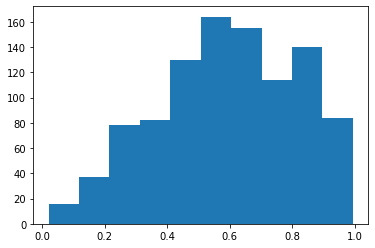

In [18]:
import matplotlib.pyplot as plt
vals = argus(chi=.5).rvs(size=1000)

# notice the semicolon, which prevents display of the return values
plt.hist(vals);

Suppose we want to plot pre-binned data, for example from our earlier `np.histogram` usage. Thanks to work by Andrzej Novak, there is now a builtin matplotlib function for plotting pre-binned histograms: `plt.stairs`.

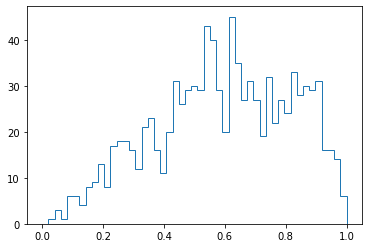

In [19]:
binning = np.linspace(0, 1, 50)

h1 = np.histogram(vals, bins=binning)
plt.stairs(*h1);

To facilitate more complex plotting, there is a package called [mplhep](https://github.com/scikit-hep/mplhep). This package is available standalone, but it is also used internally by the `hist` package to provide several convenience functions to aid in plotting `Hist` objects:

 * `plot1d`: Create a 1D plot from a 1D or 2D Hist object (see [mplhep.histplot](https://mplhep.readthedocs.io/en/latest/api.html#mplhep.histplot) for all options)

 * `plot_ratio`: Create a ratio plot, dividing two compatible histograms

 * `plot2d`: Create a 2D plot from a 2D Hist object
 
Below are some simple examples of using each function on our `histo` object.

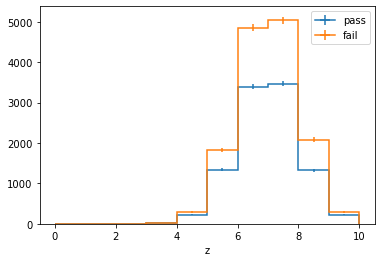

In [20]:
# plot z projection per category
h.project("cat", "z").plot1d()
plt.gca().legend();

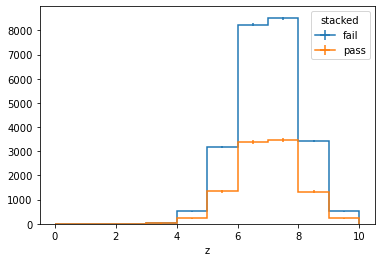

In [21]:
# plot z projection per category, stacked
h[:, ::sum, ::sum, :].plot1d(stack=True)
plt.gca().legend(title="stacked");

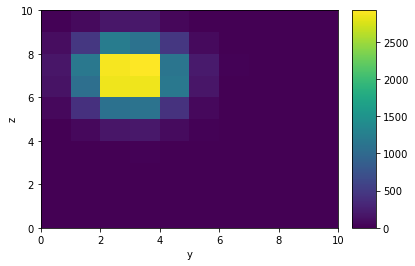

In [22]:
# plot y-z plane projection
h.project("y", "z").plot2d();

(([StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fde206e8c40>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)],
  [StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fde20702340>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]),
 RatioErrorbarArtists(line=<matplotlib.lines.Line2D object at 0x7fde207118b0>, errorbar=<ErrorbarContainer object of 3 artists>))

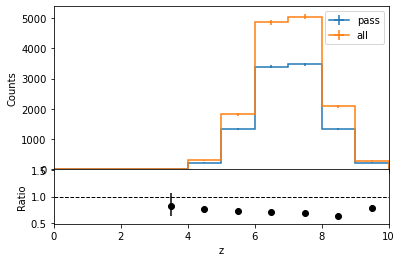

In [23]:
# plot pass vs. fail as a function of z
h["pass", ::sum, ::sum, :].plot_ratio(h["fail", ::sum, ::sum, :], rp_num_label="pass", rp_denom_label="all")

## Styling

We've covered the basics of plotting, now let's go over some styling options. To make things more interesting, we'll load some electron and muon Lorentz vectors from simulated $H\rightarrow ZZ^{*}$ events into awkward arrays and then plot some kinematic quantities for them, making liberal use of the matplotlib styling options which are exposed through the plotting utilities.

In [24]:
import uproot
import awkward as ak

fin = uproot.open("root://xcache//store/user/ncsmith/opendata_mirror/ZZTo4mu.root")
tree = fin["Events"]

electrons = tree.arrays(filter_name="Electron_*", entry_stop=100_000)
muons = tree.arrays(filter_name="Muon_*", entry_stop=100_000)

# let's build the lepton arrays back into objects 
electrons = ak.zip({k.replace('Electron_', ''): electrons[k] for k in electrons.fields})
muons = ak.zip({k.replace('Muon_', ''): muons[k] for k in muons.fields})

print("Avg. electrons/event:", np.sum(ak.num(electrons)) / tree.num_entries)
print("Avg. muons/event:", np.sum(ak.num(muons)) / tree.num_entries)

Avg. electrons/event: 0.005919026806060315
Avg. muons/event: 0.16856918717279581


In [25]:
lepton_kinematics = (
    hist.Hist.new
    .StrCat(["electron", "muon"], name="flavor", label="Lepton flavor")
    .Reg(19, 10, 100, name="pt", label="$p_{T}$")
    .Var([-2.5, -1.4, 0, 1.4, 2.5], name="eta", label="$\eta$")
    .Double()
)

# Pass keyword arguments to fill, all arrays must be flat numpy arrays
# User is responsible for ensuring all arrays have same jagged structure!
lepton_kinematics.fill(
    flavor="electron",
    pt=ak.flatten(electrons.pt),
    eta=ak.flatten(electrons.eta),
)
lepton_kinematics.fill(
    flavor="muon",
    pt=ak.flatten(muons.pt),
    eta=ak.flatten(muons.eta),
)

Hist(
  StrCategory(['electron', 'muon']),
  Regular(19, 10, 100, name='pt', label='$p_{T}$'),
  Variable([-2.5, -1.4, 0, 1.4, 2.5]),
  storage=Double()) # Sum: 167387.0 (261569.0 with flow)

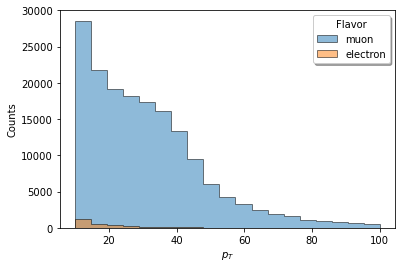

In [26]:
# Now we can start to manipulate this single histogram to plot different views of the data
# here we look at lepton pt for all eta
lepton_pt = lepton_kinematics[:, :, ::sum]

fig, ax = plt.subplots()
lepton_pt.plot1d(
    ax=ax,
    overlay="flavor",
    histtype="fill",
    stack=True,
    alpha=0.5,
    edgecolor=(0, 0, 0, 0.3),
)
# you can edit features of the plot afterwards using matplotlib object-oriented syntax
ax.set_ylabel("Counts")
# e.g. maybe you really miss '90s graphics...
ax.legend(title="Flavor", shadow=True)

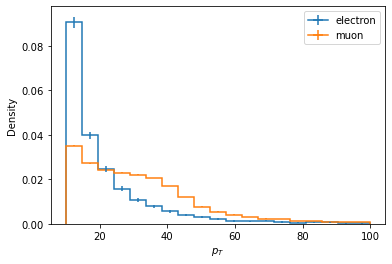

In [27]:
# Clearly the yields are much different, are the shapes similar? We can check by setting `density=True`
lepton_pt.plot1d(overlay="flavor", density=True)
plt.gca().legend()
plt.gca().set_ylabel("Density");

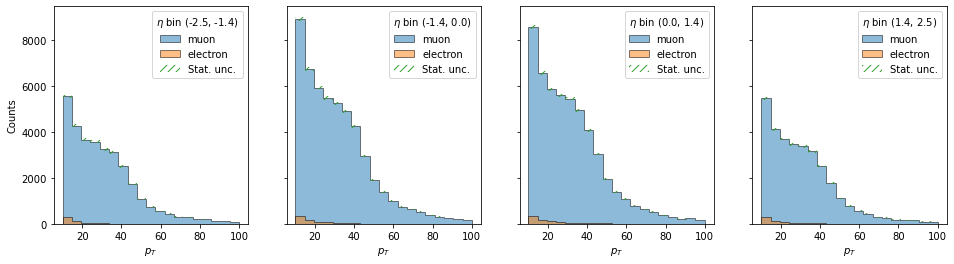

In [28]:
# compare different eta regions
eta_axis = lepton_kinematics.axes[2]
fig, axes = plt.subplots(ncols=len(eta_axis), figsize=(16, 4), sharey=True)
for i, ax in enumerate(axes):
    lepton_kinematics[:, :, i].plot1d(ax=ax, stack=True, histtype="fill", alpha=0.5, edgecolor=(0, 0, 0, 0.3))
    # create a total statistical uncertainty hatch
    tot = lepton_kinematics[::sum, :, i].view()
    ax.stairs(
        edges=lepton_kinematics.axes[1].edges,
        baseline=tot - np.sqrt(tot),
        values=tot + np.sqrt(tot),
        hatch="///",
        label="Stat. unc.",
        facecolor="none",
        linewidth=0,
    )
    ax.legend(title=f"$\eta$ bin {eta_axis[i]}")
    if i == 0:
        ax.set_ylabel("Counts")

In [29]:
# Here we create some pseudodata for the pt histogram so we can make a nice data/mc plot
total = lepton_pt[::sum, :]
data = total.copy()
data.reset()
data.fill(
    np.repeat(total.axes[0].centers, np.random.poisson(total.view()))
)
data

Hist(Regular(19, 10, 100, name='pt', label='$p_{T}$'), storage=Double()) # Sum: 166563.0

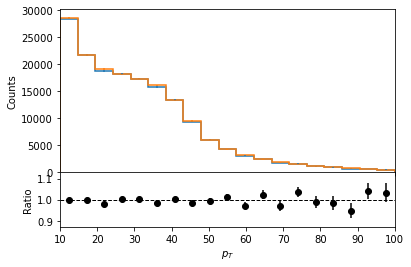

In [30]:
# the builtin ratio plot is useful for quick checks but lacks fine styling
data.plot_ratio(total);

Some further styling tools are available through the `mplhep` package. In particular, there are several stylesheets that update `plt.rcParams` to conform with experiment style recommendations regarding font face, font sizes, tick mark styles, and other such things. Below is an example application.

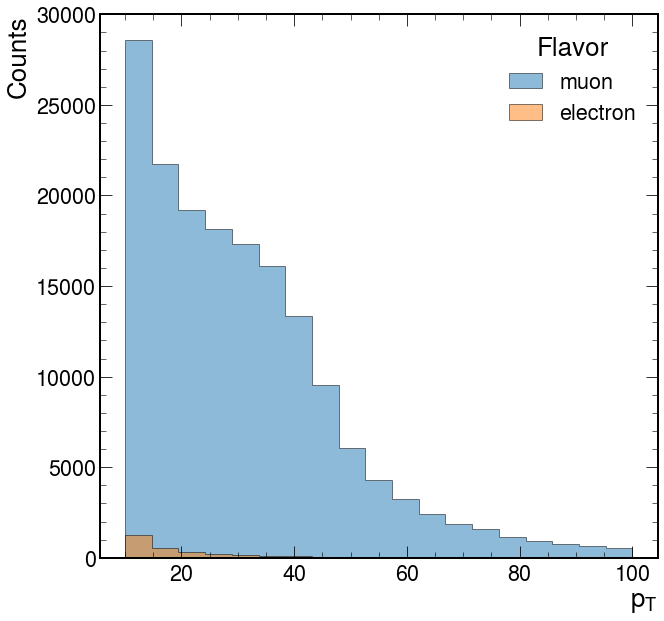

In [31]:
import mplhep
plt.style.use(mplhep.style.CMS)

# Compare this to the style of the plot drawn previously
fig, ax = plt.subplots()
lepton_pt.plot1d(
    ax=ax,
    overlay="flavor",
    histtype="fill",
    stack=True,
    alpha=0.5,
    edgecolor=(0, 0, 0, 0.3),
)
ax.set_ylabel("Counts")
ax.legend(title="Flavor")

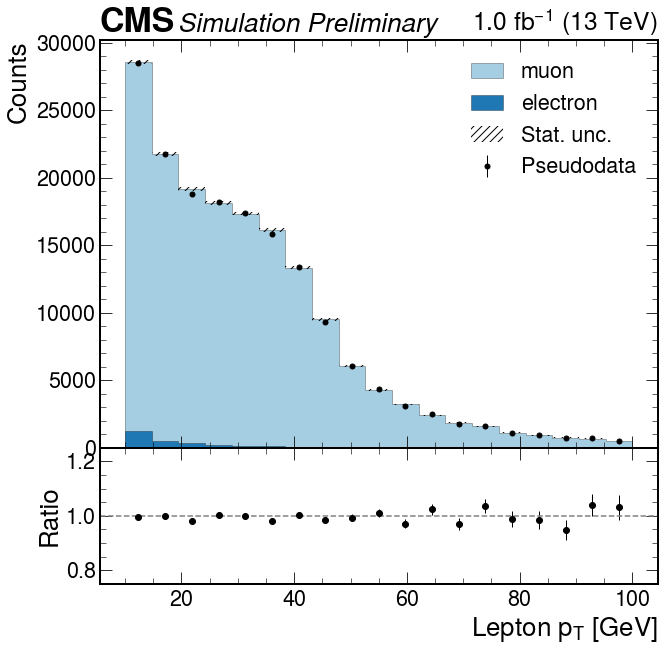

In [32]:
# define a ratio plot figure
fig, (ax, rax) = plt.subplots(2, 1, gridspec_kw=dict(height_ratios=[3, 1], hspace=0), sharex=True)

# Here is an example of setting up a color cycler to color the various fill patches
# We get the colors from this useful utility: http://colorbrewer2.org/#type=qualitative&scheme=Paired&n=6
from cycler import cycler
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']
ax.set_prop_cycle(cycler(color=colors))

# draw components
components = lepton_pt.plot1d(
    ax=ax,
    stack=True,
    histtype="fill",
    edgecolor=(0, 0, 0, 0.3),
)

# create a total statistical uncertainty hatch
ax.stairs(
    edges=lepton_kinematics.axes[1].edges,
    baseline=total - np.sqrt(total),
    values=total + np.sqrt(total),
    hatch="///",
    label="Stat. unc.",
    facecolor="none",
    linewidth=0,
    color="black",
)

data.plot1d(ax=ax, histtype="errorbar", color="k", label="Pseudodata")

ax.set_ylabel("Counts")
ax.legend()

# now draw a ratio plot
from hist.intervals import ratio_uncertainty

rax.errorbar(
    x=data.axes[0].centers,
    y=data.view() / total.view(),
    yerr=ratio_uncertainty(data.view(), total.view(), "poisson"),
    color="k",
    linestyle="none",
    marker="o",
    elinewidth=1,
)
rax.axhline(y=1.0, linestyle="dashed", color="gray")
rax.set_ylabel("Ratio", loc="center")
rax.set_ylim(0.75, 1.25)
rax.set_xlabel("Lepton $p_{T}$ [GeV]")

# add some labels
lumi = mplhep.cms.label(ax=ax, lumi=1.0, label="Preliminary")